In [6]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 15
BATCH_SIZE  =  1           # now safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=256
num_global_tokens=256
dropout=0.02
cutoff=10.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 21  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss.item())

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    scheduler.step(loss) 
    vloss.append(np.mean(vl_losses).item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")


Epoch   0 | train L1 = 1.2356
              |  val L1 = 1.1295
Epoch   1 | train L1 = 1.1770
              |  val L1 = 1.0956
Epoch   2 | train L1 = 1.1546
              |  val L1 = 1.0406
Epoch   3 | train L1 = 1.1256
              |  val L1 = 1.0146
Epoch   4 | train L1 = 1.1073
              |  val L1 = 1.0132
Epoch   5 | train L1 = 1.1076
              |  val L1 = 0.9852
Epoch   6 | train L1 = 1.1029
              |  val L1 = 0.9681
Epoch   7 | train L1 = 1.0883
              |  val L1 = 0.9632
Epoch   8 | train L1 = 1.0987
              |  val L1 = 0.9729
Epoch   9 | train L1 = 1.1257
              |  val L1 = 1.0661
Epoch  10 | train L1 = 1.1613
              |  val L1 = 1.0608
Epoch  11 | train L1 = 1.1604
              |  val L1 = 1.0141
Epoch  12 | train L1 = 1.1258
              |  val L1 = 1.0110
Epoch  13 | train L1 = 1.1140
              |  val L1 = 1.0060
Epoch  14 | train L1 = 1.0900
              |  val L1 = 1.0023
Epoch  15 | train L1 = 1.0942
              |  val L1 =

fix scheduler

In [8]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 15
BATCH_SIZE  =  1           # now safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=256
num_global_tokens=256
dropout=0.02
cutoff=10.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 21  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    L=torch.mean(torch.stack(vl_losses))
    scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")


Epoch   0 | train L1 = 1.2356
              |  val L1 = 1.1295
Epoch   1 | train L1 = 1.1770
              |  val L1 = 1.0956
Epoch   2 | train L1 = 1.1575
              |  val L1 = 1.0465
Epoch   3 | train L1 = 1.1255
              |  val L1 = 1.0123
Epoch   4 | train L1 = 1.1085
              |  val L1 = 1.0101
Epoch   5 | train L1 = 1.1098
              |  val L1 = 0.9833
Epoch   6 | train L1 = 1.1022
              |  val L1 = 0.9626
Epoch   7 | train L1 = 1.0896
              |  val L1 = 0.9661
Epoch   8 | train L1 = 1.0962
              |  val L1 = 0.9800
Epoch   9 | train L1 = 1.0910
              |  val L1 = 1.0344
Epoch  10 | train L1 = 1.1102
              |  val L1 = 1.0579
Epoch  11 | train L1 = 1.1028
              |  val L1 = 0.9507
Epoch  12 | train L1 = 1.0994
              |  val L1 = 0.9421
Epoch  13 | train L1 = 1.0836
              |  val L1 = 0.9418
Epoch  14 | train L1 = 1.0606
              |  val L1 = 0.9340
Epoch  15 | train L1 = 1.0533
              |  val L1 =

no scheduler

In [9]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 15
BATCH_SIZE  =  1           # now safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=256
num_global_tokens=256
dropout=0.02
cutoff=10.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 21  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    L=torch.mean(torch.stack(vl_losses))
    #scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)")
#os.system("wandb sync --include-offline --sync-all wandb")


Epoch   0 | train L1 = 1.2356
              |  val L1 = 1.1295
Epoch   1 | train L1 = 1.1770
              |  val L1 = 1.0956
Epoch   2 | train L1 = 1.1575
              |  val L1 = 1.0465
Epoch   3 | train L1 = 1.1255
              |  val L1 = 1.0123
Epoch   4 | train L1 = 1.1085
              |  val L1 = 1.0101
Epoch   5 | train L1 = 1.1098
              |  val L1 = 0.9833
Epoch   6 | train L1 = 1.1022
              |  val L1 = 0.9626
Epoch   7 | train L1 = 1.0896
              |  val L1 = 0.9661
Epoch   8 | train L1 = 1.0964
              |  val L1 = 0.9841
Epoch   9 | train L1 = 1.0933
              |  val L1 = 1.0415
Epoch  10 | train L1 = 1.1144
              |  val L1 = 1.0438
Epoch  11 | train L1 = 1.1100
              |  val L1 = 0.9604
Epoch  12 | train L1 = 1.0953
              |  val L1 = 0.9550
Epoch  13 | train L1 = 1.0857
              |  val L1 = 0.9498
Epoch  14 | train L1 = 1.0760
              |  val L1 = 0.9426
Epoch  15 | train L1 = 1.0604
              |  val L1 =

500 neighhb

In [11]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 200
BATCH_SIZE  =  1           # now safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.02
cutoff=20.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 10  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    L=torch.mean(torch.stack(vl_losses))
    scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")


Epoch   0 | train L1 = 1.3514
              |  val L1 = 1.1910
Epoch   1 | train L1 = 1.2250
              |  val L1 = 1.1788
Epoch   2 | train L1 = 1.2219
              |  val L1 = 1.1743
Epoch   3 | train L1 = 1.2180
              |  val L1 = 1.1764
Epoch   4 | train L1 = 1.2070
              |  val L1 = 1.1663
Epoch   5 | train L1 = 1.2033
              |  val L1 = 1.1773
Epoch   6 | train L1 = 1.1979
              |  val L1 = 1.1735
Epoch   7 | train L1 = 1.1861
              |  val L1 = 1.1799
Epoch   8 | train L1 = 1.1892
              |  val L1 = 1.1799
Epoch   9 | train L1 = 1.1859
              |  val L1 = 1.1859
Saved checkpoint_20250713_210810.pt (7.9 min) 7.94516411225001


In [ ]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 200
BATCH_SIZE  =  1           # now safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.02
cutoff=20.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 10  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    L=torch.mean(torch.stack(vl_losses))
    scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)


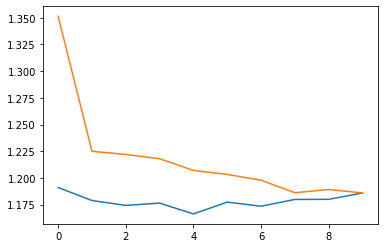

In [13]:
from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)

Epoch   0 | train L1 = 1.2774
              |  val L1 = 1.1737
Epoch   1 | train L1 = 1.2256
              |  val L1 = 1.1772
Epoch   2 | train L1 = 1.2328
              |  val L1 = 1.1695
Epoch   3 | train L1 = 1.2238
              |  val L1 = 1.1768
Epoch   4 | train L1 = 1.2128
              |  val L1 = 1.1652
Epoch   5 | train L1 = 1.2160
              |  val L1 = 1.1475
Epoch   6 | train L1 = 1.1904
              |  val L1 = 1.1052
Epoch   7 | train L1 = 1.1674
              |  val L1 = 1.0540
Epoch   8 | train L1 = 1.1476
              |  val L1 = 1.0413
Epoch   9 | train L1 = 1.1455
              |  val L1 = 1.0148
Saved checkpoint_20250713_211846.pt (3.8 min) 3.8067312598228455


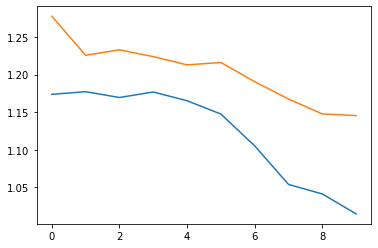

In [17]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.02
cutoff=20.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the (not) variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 10  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    L=torch.mean(torch.stack(vl_losses))
    scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)


Epoch   0 | train L1 = 1.3376
              |  val L1 = 1.1855
Epoch   1 | train L1 = 1.2257
              |  val L1 = 1.1819
Epoch   2 | train L1 = 1.2231
              |  val L1 = 1.1741
Epoch   3 | train L1 = 1.2204
              |  val L1 = 1.1762
Epoch   4 | train L1 = 1.2125
              |  val L1 = 1.1718
Epoch   5 | train L1 = 1.2018
              |  val L1 = 1.1737
Epoch   6 | train L1 = 1.1969
              |  val L1 = 1.1747
Epoch   7 | train L1 = 1.1814
              |  val L1 = 1.1865
Epoch   8 | train L1 = 1.1826
              |  val L1 = 1.1812
Epoch   9 | train L1 = 1.1824
              |  val L1 = 1.2160
Saved checkpoint_20250713_212415.pt (4.8 min) 4.841254552205403


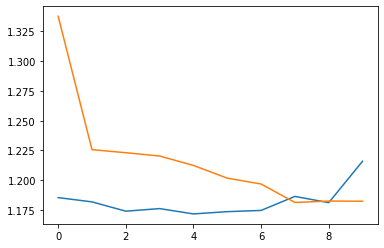

In [18]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 150
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=1000, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.02
cutoff=20.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the (not) variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 10  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())

    print(f"Epoch {epoch:3d} | train L1 = {np.mean(tr_losses):.4f}")
    tloss.append(np.mean(tr_losses).item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]

            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    print(f"              |  val L1 = {np.mean(vl_losses):.4f}")
    L=torch.mean(torch.stack(vl_losses))
    scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./{runid}-checkpoint_{timestamp}.pt")
torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)


Epoch   0 | train L1 = 1.2774
              |  val L1 = 1.1737
Epoch   1 | train L1 = 1.2256
              |  val L1 = 1.1772
Epoch   2 | train L1 = 1.2328
              |  val L1 = 1.1695
Epoch   3 | train L1 = 1.2238
              |  val L1 = 1.1768
Epoch   4 | train L1 = 1.2128
              |  val L1 = 1.1652
Epoch   5 | train L1 = 1.2160
              |  val L1 = 1.1475
Epoch   6 | train L1 = 1.1904
              |  val L1 = 1.1052
Epoch   7 | train L1 = 1.1674
              |  val L1 = 1.0540
Epoch   8 | train L1 = 1.1476
              |  val L1 = 1.0413
Epoch   9 | train L1 = 1.1455
              |  val L1 = 1.0148
Saved checkpoint_20250713_212837.pt (2.9 min) 2.866321818033854


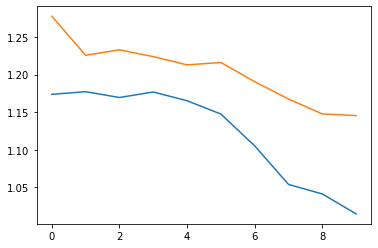

In [19]:
import datetime, time
from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None

def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 2, 8 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=3
num_heads=dim + basis 
num_edge_tokens=10
num_global_tokens=10
dropout=0.02
cutoff=20.0
num_neighbors=2



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    """
    Pads the (not) variable-length site dimension so the batch can be stacked
    into one tensor.  A boolean mask keeps track of which elements are
    real data (True) vs. padding (False).
    """
    # batch = list[(z,pos,y), ...]         len = B
    B               = len(batch)
    S_max           = max(item[0].shape[0] for item in batch)   # longest protein
    device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 , device=device)
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32, device=device)
    ys   = torch.full  ((B, S_max),  float("nan"), dtype=torch.float32, device=device)
    #ys   = torch.full  (B, S_max,               float("nan"),        dtype=torch.float32, device=device)
    mask = torch.zeros (B, S_max,                                   dtype=torch.bool,     device=device)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs  [b, :S] = z.to(device)
        pos [b, :S] = pos_b.to(device)
        ys  [b, :S] = y.to(device)
        mask[b, :S] = True

    return zs, pos, ys, mask             # shapes – see above

# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = glob.glob(INPUTS_DIR)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:20], all_paths[20:30]

train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(dim + basis, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=False,num_nearest_neighbors=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 10  # or whatever you like

config={"runid": runid,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds) + len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "num edge and global tokens": [num_edge_tokens,num_global_tokens],
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion}


# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE)
    tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); pred_head.train()
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
        preds = pred_head(feats)       
        t=preds.unsqueeze(0)
        preds=protein_egnn(t,centroids)[0]

        loss  = criterion(preds.flatten(), y_res)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)
    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); pred_head.eval()
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
            
            preds = pred_head(feats)       
            t=preds.unsqueeze(0)
            preds=protein_egnn(t,centroids)[0]



            loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss)

    #elapsed_min = (time.time() - t0) / 60
    vl=torch.mean(vl_losses)
    print(f"              |  val L1 = {vl.item():.4f}")
    L=torch.mean(torch.stack(vl_losses))
    scheduler.step(L)
    vloss.append(L.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "lin":           pred_head.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./results/{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

from matplotlib import pyplot as plt
plt.plot(vloss)
plt.plot(tloss)
